In [1]:
import requests
from bs4 import BeautifulSoup
from astropy.io import fits
import urllib.request
import re
import os
import numpy as np

In [2]:
url = "https://data.sdss.org/sas/dr17/sdss/spectro/redux/26/spectra/"

# Send a GET request to the URL and retrieve the HTML content
response = requests.get(url)
html_content = response.content

# Create a BeautifulSoup object to parse the HTML
soup = BeautifulSoup(html_content, 'html.parser')

# Find all the <a> tags and filter URLs with the desired format
urls = [a['href'] for a in soup.find_all('a') if a['href'].endswith('/') and a['href'].strip('/').isdigit()]
    
print(len(url))

61


In [3]:
len(urls)

2467

In [4]:
def download_spectra(i):
    base = 0
    url = f"https://data.sdss.org/sas/dr17/sdss/spectro/redux/26/spectra/{urls[i]}"

    # Send a GET request to the URL and retrieve the HTML content
    response = requests.get(url)
    html_content = response.content

    # Create a BeautifulSoup object to parse the HTML
    soup = BeautifulSoup(html_content, 'html.parser')

    # Find all the <a> tags that contain the filenames
    filename_tags = soup.find_all('a')

    # Extract the filenames from the <a> tags
    filenames = [tag.get('href') for tag in filename_tags]

    filenames = [filename for filename in filenames if filename.endswith(".fits")]
    
    for filename in filenames:
        
        save_path = save_directory + filename #Replace your path

        file_url = url + filename

        with fits.open(file_url) as hdulist:
            if not hdulist[2].data['class'] == 'STAR':
                urllib.request.urlretrieve(file_url, save_path)

In [ ]:
# Create a ThreadPoolExecutor
import concurrent.futures
with concurrent.futures.ThreadPoolExecutor(max_workers=36) as executor:
    # Use list comprehension to create a list of tasks to execute
    # Each task is a call to download_image with an index and a pair of coordinates
    tasks = [ executor.submit(download_spectra, i) for i in range(0,len(urls)) ]

    # Wait for all tasks to complete
    for future in concurrent.futures.as_completed(tasks):
        # If the task raised an exception, it will be re-raised here
        future.result()

0
0
0
0
0
0
0
0
0
0
0


In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = "DejaVu Serif"
mpl.rcParams['mathtext.fontset'] = "cm"
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

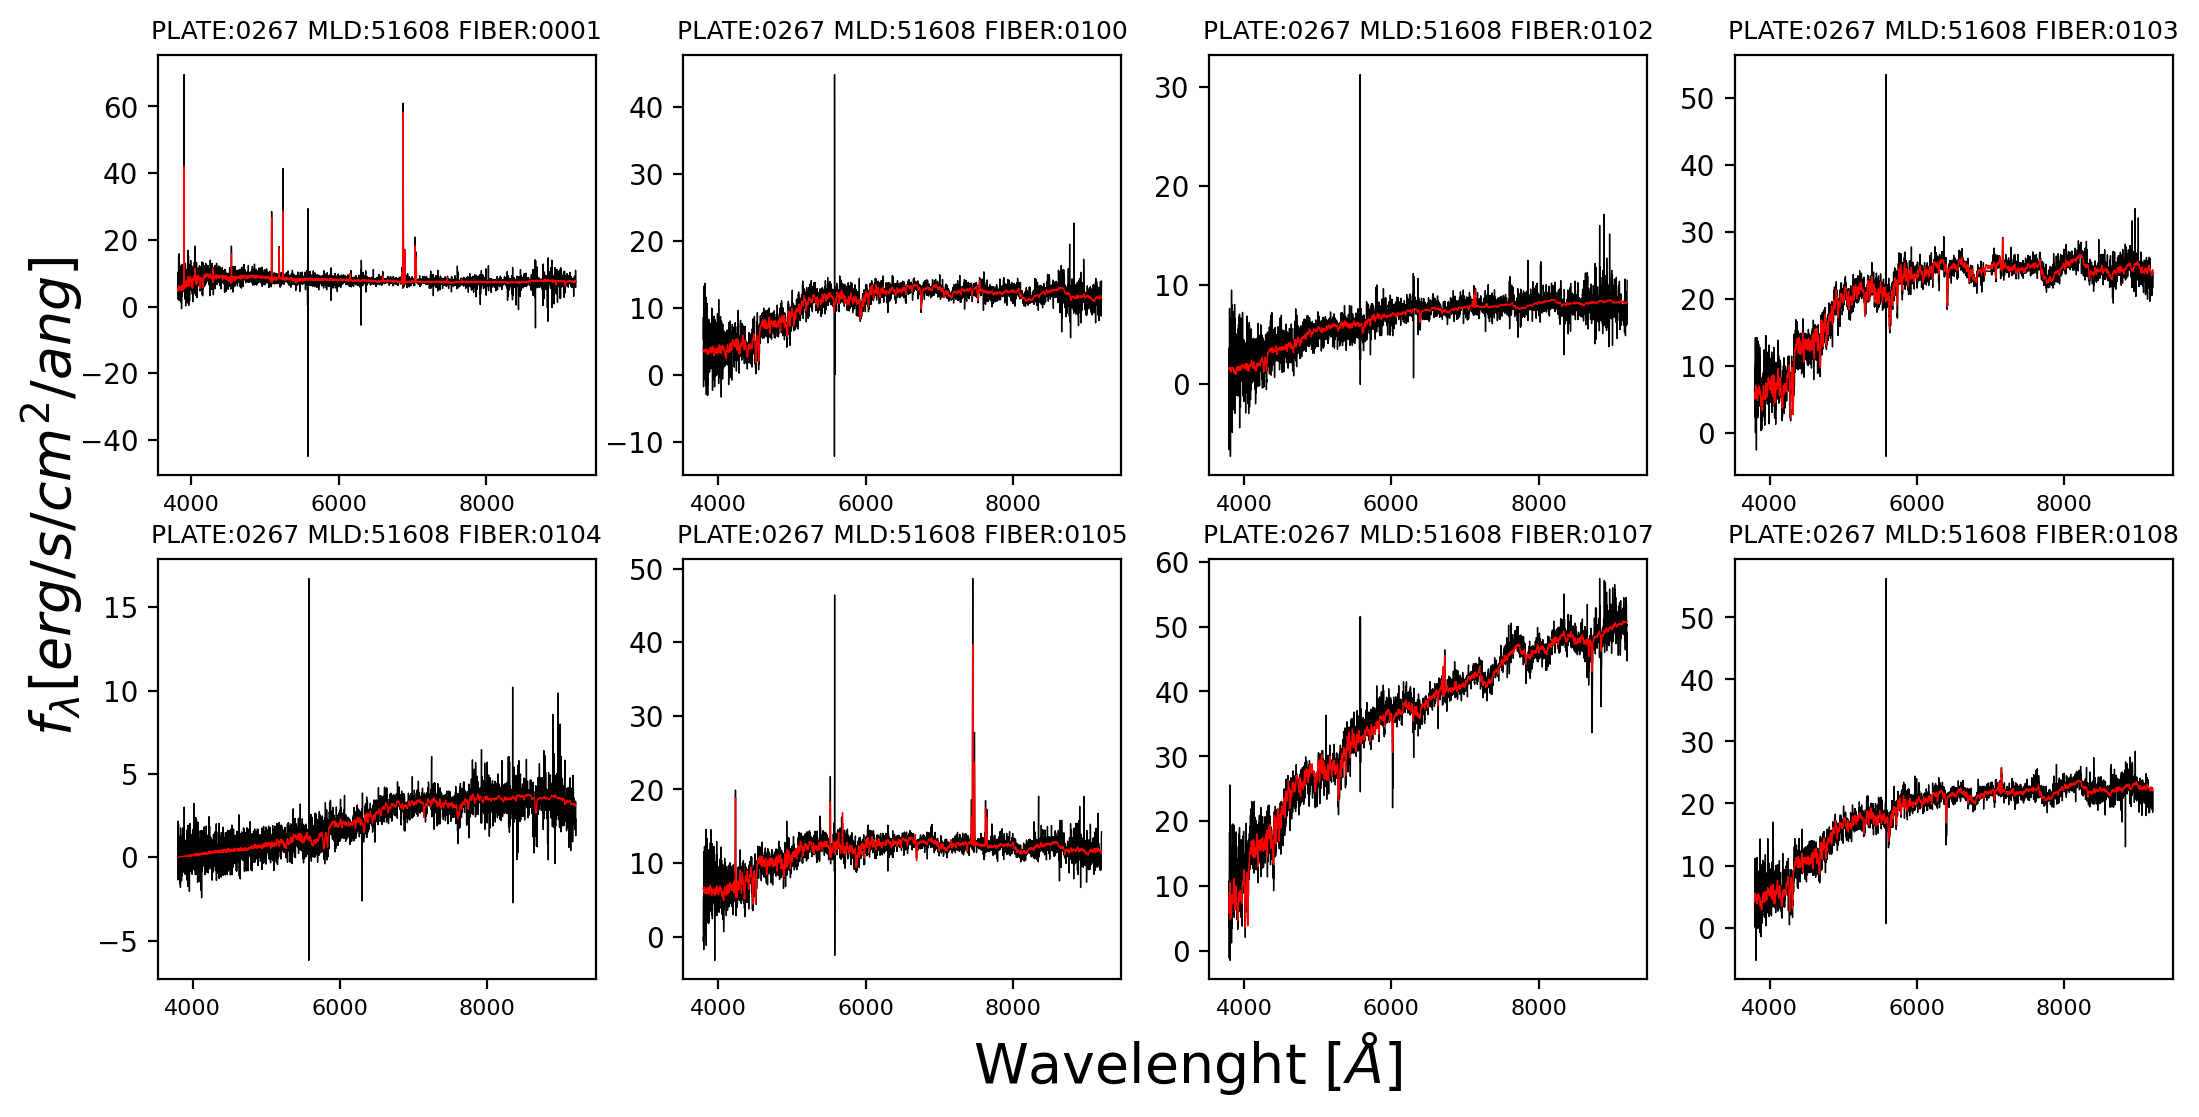

In [9]:
pattern = r"spec-(\d+)-(\d+)-(\d+)\.fits"

# Specify the directory path
directory_path = ...

# List all files and folders in the directory
plates = os.listdir(directory_path)
i = 1
directory_path_plate = directory_path + plates[i]

filenames = os.listdir(directory_path)

plt.figure(figsize=(13,6),dpi=200)
for n in range(8):
    plt.subplot(2,4,n+1)
    
    file_path = directory_path + filenames[n]

    hdulist = fits.open(file_path)
    redshift = hdulist[2].data['Z'][0]
    if redshift < 0:
        redshift = 0
    galaxy_class = hdulist[2].data['class'][0]
    if galaxy_class == 'GALAXY':
        # load data
        flux = hdulist[1].data['flux']
        model_flux = hdulist[1].data['model']
        ivar = hdulist[1].data['ivar']
        wave = hdulist[1].data['loglam']
        ivar[ivar==0] = np.nan
        plt.plot(10**wave,flux,c='k',lw=.5)
        plt.plot(10**wave,model_flux,c='r',lw=.5)
        plt.xticks(fontsize=8)
        match = re.match(pattern,filenames[n])
        plt.title(f'PLATE:{match.groups()[0]} MLD:{match.groups()[1]} FIBER:{match.groups()[2]}',fontsize=9)
        match.groups()
        if n == 5:
            plt.xlabel('Wavelenght $[\AA]$',fontsize = 20,x=1.15)
        elif n == 4:
            plt.ylabel('$f_{\lambda}[erg/ s/ cm^{2}/ ang$]',fontsize = 20,y=1.15)

plt.savefig('/home/daikiiwasaki/Figure-Master/Figure/Row_spectra.pdf',bbox_inches="tight",dpi=200)
plt.show()